<a href="https://colab.research.google.com/github/maikejulie/DNN4Cli/blob/main/THOR/LRPonECCO/LRP_ECCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# LRP - Bayesian Approach

To explain the skill of the Bayesian Neural Network (BNN), we use `LRP` (Layerwise Relevance Propagation). We apply LRP to an ensemble of deterministic neural networks which are trivially generated from the BNN.

Note we use LRPz and apply it on a gridpoint by gridpoint basis.

In [3]:
!pip uninstall keras -y

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0


Installing the version of Keras 2.2.4 for LRP compatibility

In [4]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.


Install a very handy library providing a common interface and out-of-the-box implementation that we use to calculate the LRP values

In [5]:
!pip install git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-f7lheljv
  Running command git clone -q https://github.com/albermax/innvestigate.git /tmp/pip-req-build-f7lheljv
  Running command git checkout -b updates_towards_tf2.0 --track origin/updates_towards_tf2.0
  Switched to a new branch 'updates_towards_tf2.0'
  Branch 'updates_towards_tf2.0' set up to track remote branch 'updates_towards_tf2.0' from 'origin'.
     |████████████████████████████████| 421.8 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 44.4 MB/s 
     |████████████████████████████████| 448 kB 54.9 MB/s 
  Created wheel for innvestigate: filename=innvestigate-2.0.0-py3-none-any.whl size=103616 sha256=d39e0a40da366a4a9f6d6ecab29f1fc76a1809f2380622559cad8f128cfacf0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1rrx5qk/wheels/99/56/02/c68d46873c61b27d2b31d62100a696ca4cb4c3390232795db7
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl si

Install a specific version of h5py

In [6]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
import innvestigate.utils as iutils
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRPEpsilon

In [8]:
TotalDataset = np.load('/content/gdrive/MyDrive/DNN4Cli/THOR/LRPonECCO/TotalDatasetECCO.npy')
missingdataindex = np.load('/content/gdrive/MyDrive/DNN4Cli/THOR/LRPonECCO/MissdataECCO.npy')

Load scaler generated during Step 2

In [9]:
from pickle import load
scaler = load(open('/content/gdrive/MyDrive/DNN4Cli/THOR/ApplicationOnCMIPModels/scaler_v1.pkl', 'rb'))
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

Calculate the LRP values of the 1000 deterministic neural networks sampled in THOR - Step_2_Bayesian_approach. Note due to issues of computer memory, you may not be able to run the full loop in one go but have split the LRP calculation into groups of 200 and then combine the list of LRP values after.

Using this ensemble is much more efficient than the deterministic ensemble used in Sonnewald et al. (2021) because we do not have to re-train the network 1000 times

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

LRP_list = []

for i in range(1000):
    det_model = Sequential([Dense(input_shape = (8,), units = 24, activation = tf.keras.activations.tanh),
       Dense(units = 24, activation = tf.keras.activations.tanh),
       Dense(units = 16, activation = tf.keras.activations.tanh),
       Dense(units = 16, activation = tf.keras.activations.tanh),
       Dense(units = 6)])

    det_model.load_weights('/content/gdrive/MyDrive/DNN4Cli/THOR/bayesian_ensemble/model_' + str(i) + '.h5')
    det_model_def = tf.keras.models.Model(
        inputs=det_model.inputs, outputs=det_model.outputs, name=det_model.name
     )
    LRP_analyzer = LRPEpsilon(det_model_def)
    analysisLRP = LRP_analyzer.analyze(scaler.transform(TotalDataset))
    analysisLRP[list(analysisLRP.keys())[0]]
    LRP_list.append(analysisLRP[list(analysisLRP.keys())[0]])

We scale and importantly take the *mean* of the ensemble of LRPs.

In [12]:
LRP_concat = np.array(LRP_list)
LRP_ensemble_scaled = LRP_concat/np.max(np.abs(LRP_concat),axis=2, keepdims=True)

In [13]:
sizeflat = 360,720

In [14]:
monthlySSH = xr.open_mfdataset('/content/gdrive/MyDrive/SSHdata/SSH.*.nc', combine='by_coords')
lat = monthlySSH['lat']
lon = monthlySSH['lon']

Plot the 25th, 50th and 75th quantiles of the ensemble of LRP values for each input feature

curl_tau


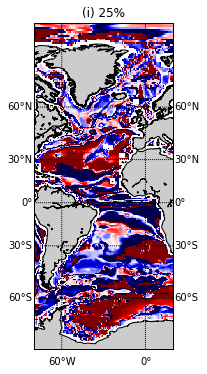

curl_tau


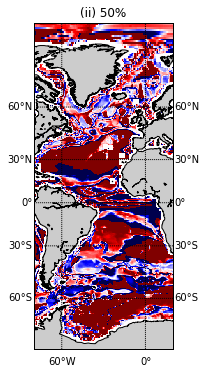

curl_tau


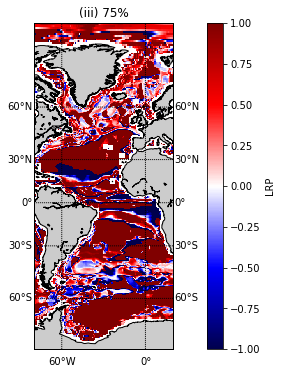

ssh_mean


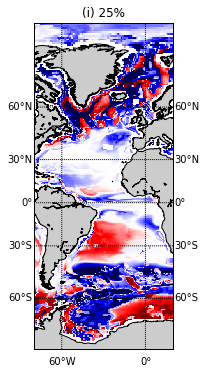

ssh_mean


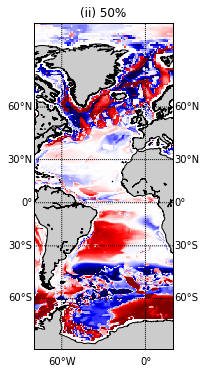

ssh_mean


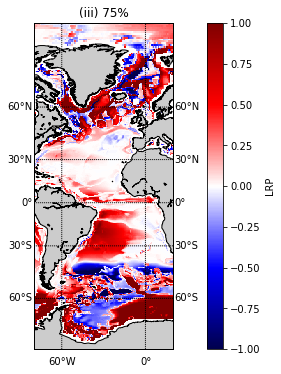

gradSSHx


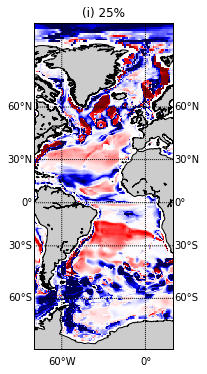

gradSSHx


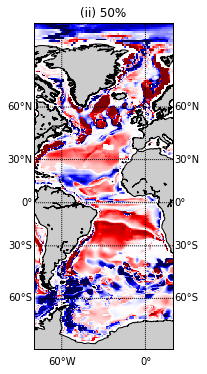

gradSSHx


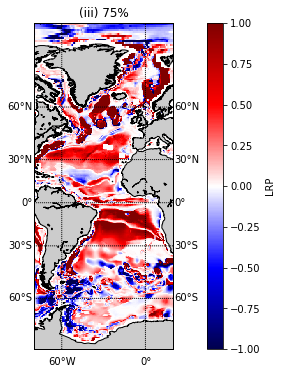

gradSSHy


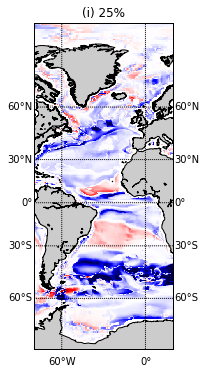

gradSSHy


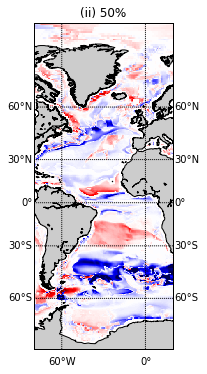

gradSSHy


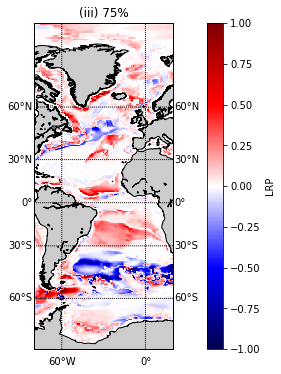

bathm


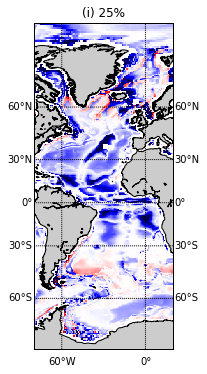

bathm


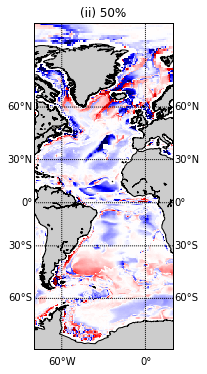

bathm


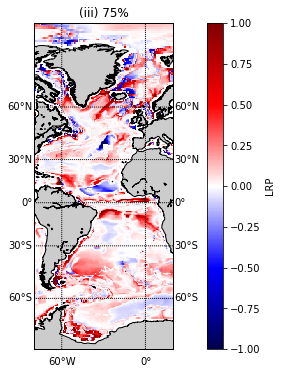

gradxbathm


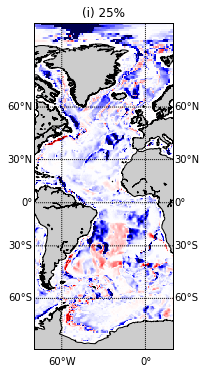

gradxbathm


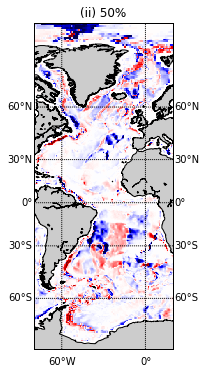

gradxbathm


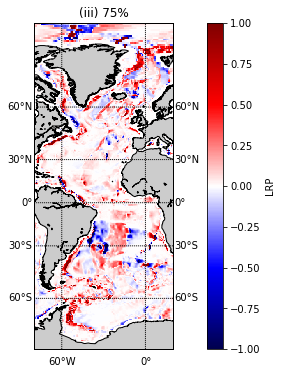

gradybathm


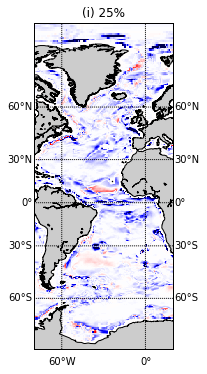

gradybathm


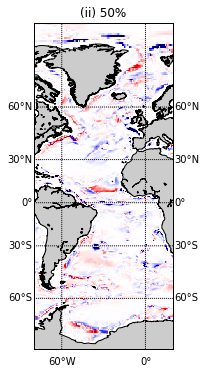

gradybathm


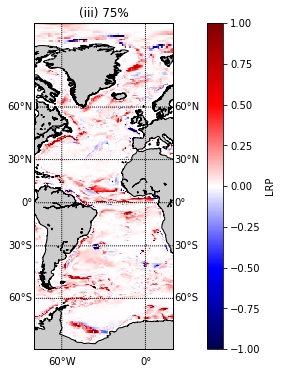

F


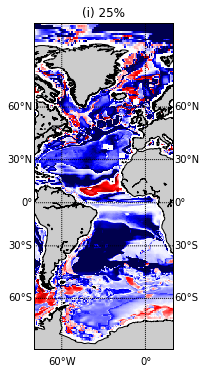

F


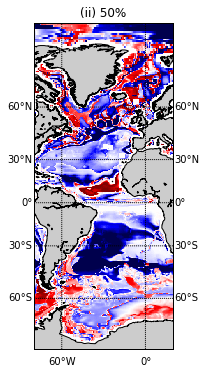

F


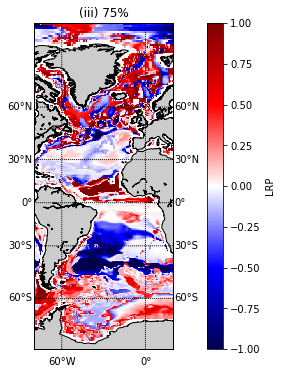

In [15]:
def alpha_plots(variable_name, number, alpha, fig_subplot, fig_row = 1, fig_col = 3):
    plt.rcParams["figure.figsize"] = (12,6)
    ensemble = LRP_ensemble_scaled[:, :, number]
    ds_alpha = np.zeros((sizeflat[0]*sizeflat[1]))
    ds_percentile = np.percentile(ensemble, alpha, axis = 0)
    ds_alpha[~missingdataindex.flatten()] = ds_percentile
    lons = lon[1,:].values
    lats = lat[:,1].values
    llons, llats = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    im = m.pcolor(llons, llats, np.flipud(np.reshape(ds_alpha,sizeflat))[::-1,:], cmap='seismic', latlon=True)   
    plt.clim(-1, 1)
    if alpha == 75:
        plt.title('(iii) 75%')
        cbar = plt.colorbar()
        cbar.set_label('LRP')
    elif alpha == 25:
        plt.title('(i) 25%')
    elif alpha == 50:
        plt.title('(ii) 50%') 
    print(variable_name)  
    plt.show()
    return ds_alpha

curl_25 = alpha_plots('curl_tau', 0, 25, 1, fig_row = 1)
curl_50 = alpha_plots('curl_tau', 0, 50, 2, fig_row = 1)
curl_75 = alpha_plots('curl_tau', 0, 75, 3, fig_row = 1)

ssh_25 = alpha_plots('ssh_mean', 1, 25, 1, fig_row = 1)
ssh_50 = alpha_plots('ssh_mean', 1, 50, 2, fig_row = 1)
ssh_75 = alpha_plots('ssh_mean', 1, 75, 3, fig_row = 1)

ssh_x_25 = alpha_plots('gradSSHx', 2, 25, 1, fig_row = 1)
ssh_x_50 = alpha_plots('gradSSHx', 2, 50, 2, fig_row = 1)
ssh_x_75 = alpha_plots('gradSSHx', 2, 75, 3, fig_row = 1)

ssh_y_25 = alpha_plots('gradSSHy', 3, 25, 1, fig_row = 1)
ssh_y_50 = alpha_plots('gradSSHy', 3, 50, 2, fig_row = 1)
ssh_y_75 = alpha_plots('gradSSHy', 3, 75, 3, fig_row = 1)

bath_25 = alpha_plots('bathm', 4, 25, 1, fig_row = 1)
bath_50 = alpha_plots('bathm', 4, 50, 2, fig_row = 1)
bath_75 = alpha_plots('bathm', 4, 75, 3, fig_row = 1)

bath_x_25 = alpha_plots('gradxbathm', 5, 25, 1, fig_row = 1)
bath_x_50 = alpha_plots('gradxbathm', 5, 50, 2, fig_row = 1)
bath_x_75 = alpha_plots('gradxbathm', 5, 75, 3, fig_row = 1)

bath_y_25 = alpha_plots('gradybathm', 6, 25, 1, fig_row = 1)
bath_y_50 = alpha_plots('gradybathm', 6, 50, 2, fig_row = 1)
bath_y_75 = alpha_plots('gradybathm', 6, 75, 3, fig_row = 1)

F_25 = alpha_plots('F', 7, 25, 1, fig_row = 1)
F_50 = alpha_plots('F', 7, 50, 2, fig_row = 1)
F_75 = alpha_plots('F', 7, 75, 3, fig_row = 1)

Plot the LRP values which are consistently positive or consistently negative from the 25th to the 75th quantiles
of the ensemble

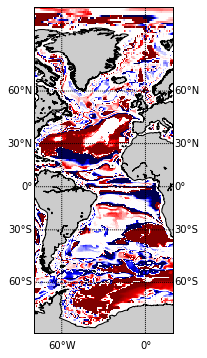

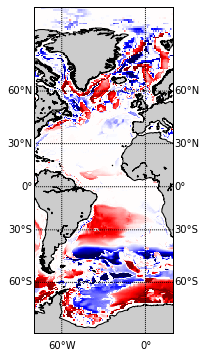

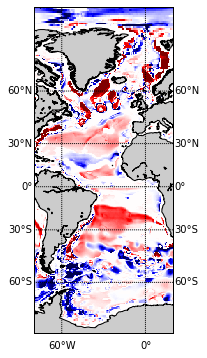

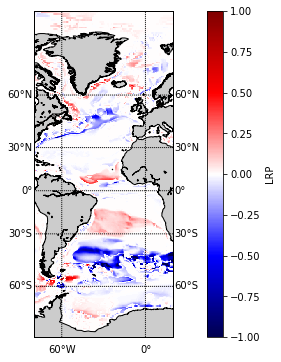

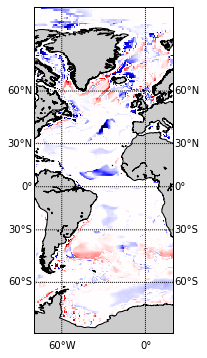

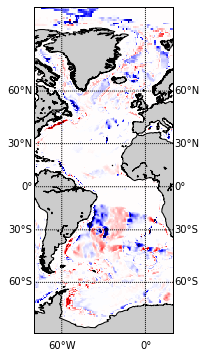

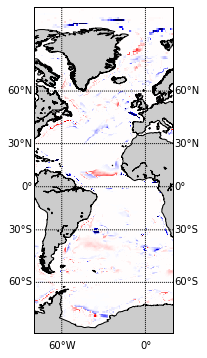

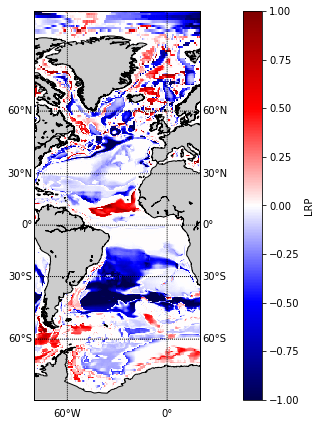

In [16]:
def consist_LRP_percentile(lower_per, upper_per, fig_subplot):
    LRP_consit_full = np.zeros((sizeflat[0]*sizeflat[1]))
    LRP_consit_full[upper_per < 0] = upper_per[upper_per < 0]
    LRP_consit_full[lower_per > 0] = lower_per[lower_per > 0]

    lons = lon[1,:].values
    lats = lat[:,1].values
    llons, llats = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    m.pcolor(llons, llats, np.flipud(np.reshape(LRP_consit_full,sizeflat))[::-1,:], cmap='seismic', latlon=True) 
    plt.clim(-1, 1)
    if fig_subplot == 4:
        cbar = plt.colorbar()
        cbar.set_label('LRP')
    elif fig_subplot == 8:
        cbar = plt.colorbar()
        cbar.set_label('LRP')    
    return LRP_consit_full

consist_curl_tau = consist_LRP_percentile(curl_25, curl_75, 1)
plt.show()
consist_ssh_mean = consist_LRP_percentile(ssh_25, ssh_75, 2)
plt.show()
consist_gradsshx = consist_LRP_percentile(ssh_x_25, ssh_x_75, 3)
plt.show()
consist_gradsshy = consist_LRP_percentile(ssh_y_25, ssh_y_75, 4)
plt.show()
consist_bathm = consist_LRP_percentile(bath_25, bath_75, 5)
plt.show()
consist_gradxbathm = consist_LRP_percentile(bath_x_25, bath_x_75, 6)
plt.show()
consist_gradybathm = consist_LRP_percentile(bath_y_25, bath_y_75, 7)
plt.show()
consist_F = consist_LRP_percentile(F_25, F_75, 8)
plt.tight_layout()
plt.show()
